In [1]:
#LSTM Auto Encoder model
#https://sci2lab.github.io/ml_tutorial/autoencoder/  Some code have been taken from this refrence. We combined some ideas from meduim with this site

In [ ]:
#https://shagunuppal.github.io/publication/MGP_VAE/

In [1]:
import os
import subprocess
classpath = os.environ['CLASSPATH']
hadoop_path = os.path.join(os.environ['HADOOP_PREFIX'], 'bin', 'hadoop')
hadoop_classpath = subprocess.check_output([hadoop_path, 'classpath', '--glob']).decode()
os.environ['CLASSPATH']=classpath + os.pathsep + hadoop_classpath

def getGpuDevices(max_number_of_gpus):
    """Finds available GPUs up to max_number_of_gpus"""
    num_gpus=0
    nodes = subprocess.check_output(["nvidia-smi", "--format=csv,noheader,nounits", "--query-gpu=memory.total,memory.free"]).decode()
    gpu_info_arr = [x for x in nodes.split('\n') if len(x) > 0]
    cuda_visible_devices=[]

    for cuda_visible_device, memory in enumerate(gpu_info_arr):
        total_mem, free_mem = memory.split(',')

        total_mem = total_mem.strip()
        free_mem = free_mem.strip()

        if (total_mem == free_mem):
            cuda_visible_devices.append(cuda_visible_device)
            num_gpus=num_gpus+1
            if (num_gpus>=max_number_of_gpus):
                break

    return cuda_visible_devices

In [2]:
MODEL_VERSION= "10F-100E-F1"

In [3]:
import tensorflow as tf
#import tensorflow_hub as hub
import numpy as np
import os
import re
import pandas as pd
import sys

In [4]:
import site
site.addsitedir("./tmp")
from PIL import Image

In [5]:
# Try to allocate 2 GPUs
# Note: if you want to allocate more, make sure to also increase the driver memory accordingly (27GB x num_gpus in Jet Blue, 160GB x num_gpus in Kessel/Polaris)
gpu_list = getGpuDevices(2)

# Set available GPUs for TensorFlow
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, gpu_list))
print("Reserved GPUs: {}".format(os.environ['CUDA_VISIBLE_DEVICES']))
print(len(gpu_list))

Reserved GPUs: 0,1
2


In [6]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [7]:
# Check that this is GPU instead of CPU version of TensorFlow
assert(tf.test.is_gpu_available() == True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
#!pip install --target=./tmp  imageio

In [9]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [10]:
!hdfs dfs -copyToLocal /user/fwaseem/UCSD_Anomaly_Dataset.tar.gz /tmp/
!gunzip /tmp/UCSD_Anomaly_Dataset.tar.gz

In [11]:
!tar xvf /tmp/UCSD_Anomaly_Dataset.tar

UCSD_Anomaly_Dataset.v1p2/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/139.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/051.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/166.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/136.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/178.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/043.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/167.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/004.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/171.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/157.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/119.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/141.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/113.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/162.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/175.tif
UCSD_An

In [12]:
!ls UCSD*
BASE = "UCSD_Anomaly_Dataset.v1p2/UCSDped1/"

README.txt  README.txt~  UCSDped1  UCSDped2


In [13]:
!ls UCSD_Anomaly_Dataset.v1p2/UCSDped1/

Test  Train


In [14]:
class Config:
  DATASET_PATH =BASE + "Train"
  DATASET_PATH_TEST =BASE + "Test"  
  BATCH_SIZE = 4
  EPOCHS = 5
  MODEL_PATH = "anomaly-model.hdf5"
  FRAME_SIZE=10  

In [15]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips



def get_training_set(seqSize = Config.FRAME_SIZE):
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seqSize))
    return clips

def get_test_set( TEST_PATH, seqSize = Config.FRAME_SIZE):
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(TEST_PATH)):
        directory_path = join(TEST_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seqSize))
    return clips



In [16]:
training_set = get_training_set()
training_set = np.array(training_set)

In [17]:
shape = training_set.shape
shape

(1360, 10, 256, 256, 1)

In [18]:
!ls UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train001

001.tif  024.tif  047.tif  070.tif  093.tif  116.tif  139.tif  162.tif	185.tif
002.tif  025.tif  048.tif  071.tif  094.tif  117.tif  140.tif  163.tif	186.tif
003.tif  026.tif  049.tif  072.tif  095.tif  118.tif  141.tif  164.tif	187.tif
004.tif  027.tif  050.tif  073.tif  096.tif  119.tif  142.tif  165.tif	188.tif
005.tif  028.tif  051.tif  074.tif  097.tif  120.tif  143.tif  166.tif	189.tif
006.tif  029.tif  052.tif  075.tif  098.tif  121.tif  144.tif  167.tif	190.tif
007.tif  030.tif  053.tif  076.tif  099.tif  122.tif  145.tif  168.tif	191.tif
008.tif  031.tif  054.tif  077.tif  100.tif  123.tif  146.tif  169.tif	192.tif
009.tif  032.tif  055.tif  078.tif  101.tif  124.tif  147.tif  170.tif	193.tif
010.tif  033.tif  056.tif  079.tif  102.tif  125.tif  148.tif  171.tif	194.tif
011.tif  034.tif  057.tif  080.tif  103.tif  126.tif  149.tif  172.tif	195.tif
012.tif  035.tif  058.tif  081.tif  104.tif  127.tif  150.tif  173.tif	196.tif
013.tif  036.tif  059.tif  082.tif  105.tif  128.tif

In [19]:
import os
current_dir = os.getcwd()

In [20]:
!pip install --target=./tmp tensorflow-probability

# to generate gifs
!pip install --target=./tmp imageio
#!pip install --target=./tmp git+https://github.com/tensorflow/docs

Looking in indexes: https://edge.dist.yahoo.com:4443/artifactory/api/pypi/pypi/simple, https://edge.dist.yahoo.com:4443/pypimirror/simple
     |████████████████████████████████| 4.8 MB 26.1 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 44.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 26.3 MB/s eta 0:00:01�████▎                         | 2.9 MB 26.3 MB/s eta 0:00:01/s eta 0:00:01     |██████████████████████████      | 12.1 MB 26.3 MB/s eta 0:00:01
ERROR: librosa 0.8.0 requires pooch>=1.0, which is not installed.
ERROR: tfx-bsl 0.22.1 has requirement pyarrow<0.17,>=0.16.0, but you'll have pyarrow 1.0.0 which is incompatible.
ERROR: tfx-bsl 0.22.1 has requirement tensorflow-metadata<0.23,>=0.22.2, but you'll have tensorflow-metadata 0.23.0 which is incompatible.
ERROR: tensorflow-data-validation 0.22.2 has requirement pyarrow<0.17,>=0.16, but you'll have pyarrow 1.0.0 which is incompatible.
ERROR: tensorflow-data-validation 0.22.2 has requirement ten

In [21]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [22]:
import tensorflow as tf
from tensorflow_probability  import distributions as tfd
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

In [23]:
Config.FRAME_SIZE

10

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, LSTM, TimeDistributed, ConvLSTM2D, MaxPooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.layers import Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import TensorBoard

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sample_z(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps



image_width  = 256
image_height = 256
latent_dim   = 32
no_epochs    = 10
batch_size   = 4
num_channels = 1

# Defining the encoder
inputs = Input(shape=( Config.FRAME_SIZE, image_width, image_height, 1), name='encoder_input')  
x= TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"))(inputs)
x = BatchNormalization()(x)
x= TimeDistributed(Conv2D(64, (5, 5), strides=4, padding="same"))(inputs)
x = BatchNormalization()(x)
x = ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True, activation="relu")(x)
x = BatchNormalization()(x)
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(latent_dim)(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# use reparameterization trick to push the sampling out as input
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])


encoder = Model(inputs, [mu, sigma, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 10, 256, 256 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 10, 64, 64, 6 1664        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 10, 64, 64, 6 256         time_distributed_1[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 10, 64, 64, 1 46144       batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [25]:
conv_shape 

(None, 10, 64, 64, 16)

In [26]:
# Defining decoder
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3] * conv_shape[4] , activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3], conv_shape[4] ))(x)
x     = ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True)(x)
x    =  BatchNormalization()(x)
x      = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=4, padding="same"))(x)
cx     = BatchNormalization()(x)
#o    = TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding='same', activation='relu'))(x)
#cx    = BatchNormalization()(cx)
o     = TimeDistributed(Conv2DTranspose(1, (11, 11), activation='sigmoid', padding='same', name='decoder_output'))(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 655360)            21626880  
_________________________________________________________________
batch_normalization_4 (Batch (None, 655360)            2621440   
_________________________________________________________________
reshape (Reshape)            (None, 10, 64, 64, 16)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 64, 64, 16)    18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 64, 64, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 256, 256, 64)  2566

In [27]:
# Build VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 10, 256, 256, 1)] 0         
_________________________________________________________________
encoder (Functional)         [(None, 32), (None, 32),  21021920  
_________________________________________________________________
decoder (Functional)         (None, 10, 256, 256, 1)   24300545  
Total params: 45,322,465
Trainable params: 44,011,361
Non-trainable params: 1,311,104
_________________________________________________________________


In [28]:
def vae_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * image_width * image_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [29]:
batch_size=4
batch_size

4

In [34]:
no_epochs=25
n_epochs=25

In [31]:
BATCH_SIZE = 4
SAVE_PERIOD = 25

# Create a callback that saves the model's weights every 10 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/tmp/checkpoint", 
    verbose=1, 
    save_weights_only=True,
    save_freq= 500)


In [32]:
vae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False)
vae.fit(training_set, training_set,
        epochs=no_epochs,
        batch_size=batch_size,
        callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1360 samples
Epoch 1/25
1360/1360 [==============================] - 76s 56ms/sample - loss: 39120.5976
Epoch 2/25
1360/1360 [==============================] - 75s 55ms/sample - loss: 38218.8499
Epoch 3/25
1360/1360 [==============================] - 75s 55ms/sample - loss: 38130.3095
Epoch 4/25
1360/1360 [==============================] - 76s 56ms/sample - loss: 38069.6993
Epoch 5/25
1360/1360 [==============================] - 74s 55ms/sample - loss: 38037.2765
Epoch 6/25
1360/1360 [==============================] - 75s 55ms/sample - loss: 38009.5579
Epoch 7/25
1360/1360 [==============================] - 75s 55ms/sample - loss: 37991.0535
Epoch 8/25
1360/1360 [==============================] - 74s 54ms/sample - loss: 37967.1158
Epoch 9/25
1360/1360 [==============================] - 75s 55ms/sample - loss: 37946.2481
Epoch 10/25
1360/1360 [==============================] - 75s 55ms/sample - loss: 37936.9665
Epoch 11/25
1360/1360 [==============================] - 75s 55ms/s

In [44]:
h = Out[32]

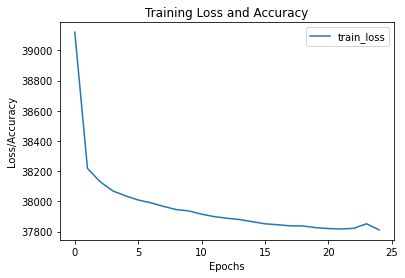

In [45]:
# plot the train and validation losses
N = np.arange(0, n_epochs)
plt.figure()
plt.plot(N, h.history['loss'], label='train_loss')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='upper right')

In [46]:
def get_single_test(test_path):
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(test_path)):
        if str(join(test_path, f))[-3:] == "tif":
            img = Image.open(join(test_path, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [47]:
modelFile= MODEL_VERSION +'_vae_0.hdf5'
vae.save(modelFile)

In [49]:
print(modelFile)

10F-100E-F1_vae_0.hdf5


In [50]:
!hdfs dfs -copyFromLocal  10F-100E-F1_vae_0.hdf5 /user/fwaseem/videoanomaly/models/10F-100E-F1_vae_0.hdf5

In [51]:
testData = get_single_test(BASE + "/Train/Train033")
testData.shape

(200, 256, 256, 1)

In [52]:
import matplotlib.pyplot as plt

def evaluate(model, test_path, fileName):

    print("got model")
    test = get_single_test(test_path)
    print("got test")
    sz = test.shape[0] - Config.FRAME_SIZE
    sequences = np.zeros((sz, Config.FRAME_SIZE, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((Config.FRAME_SIZE, 256, 256, 1))
        for j in range(0, Config.FRAME_SIZE):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    np.save(fileName, sr) 
    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

got model
got test
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


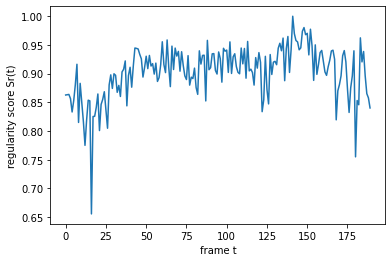

In [53]:
evaluate(vae, BASE + "/Train/Train033", "/tmp/train033_pickle")

got model
got test


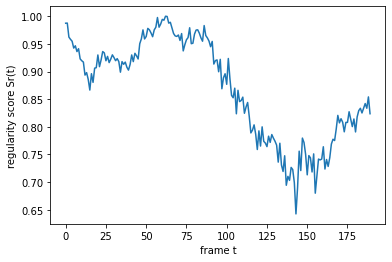

In [54]:
evaluate(vae, BASE + "/Test/Test005", "/tmp/train005_pickle")

got model
got test


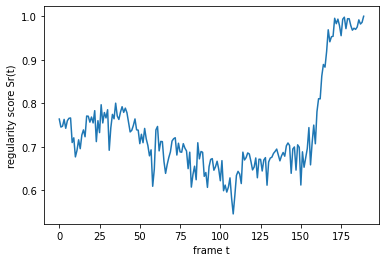

In [55]:
evaluate(vae,  BASE + "/Test/Test024", "/tmp/train024_pickle")

In [56]:
def evaluate(model, test_path, fileName):

    print("got model")
    test = get_single_test(test_path)
    print("got test")
    sz = test.shape[0] - 5
    sequences = np.zeros((sz, 5, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((5, 256, 256, 1))
        for j in range(0, 5):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    np.save(fileName, sr) 
    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [57]:
from PIL import Image as im
import matplotlib.pyplot as plt
def plotImages(orig_image, reconst_image, orig_image2, reconst_image2):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    # setting values to rows and column variables
    rows = 2
    columns = 2
  
    
  
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
  
    # showing image
    plt.imshow(orig_image)
    plt.axis('off')
    plt.title("original")
  
    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)
  
    # showing image
    plt.imshow(reconst_image)
    plt.axis('off')
    plt.title("reconstruct")
  
    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)
  
    # showing image
    plt.imshow(orig_image2)
    plt.axis('off')
    plt.title("original")
  
    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)
  
    # showing image
    plt.imshow(reconst_image2)
    plt.axis('off')
    plt.title("reconstruct")

In [58]:
def extractImage(clip_images, i, j):
    
     clip_image = clip_images[i, j,:,:,:]       
     clip_image = clip_image.squeeze()
     clip_image = clip_image.reshape(clip_image.shape[0], clip_image.shape[1], 1)
     return  clip_image  

In [63]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def visualize(model, test_path ): 
    """ Visualizes the original images and the reconstructed ones for `n_samples` examples 
    on the test set `X_test`."""
      
    print("got model")
    test = get_single_test(test_path)
    print("got test")
    sz = test.shape[0] - 10
    original_images = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        original_images[i] = clip

    reconstructed_images = model.predict(original_images,batch_size=4)
    print("shape of reconstructed images " + str(original_images.shape))  
    print("shape of reconstructed images " + str(reconstructed_images.shape))
    # Displaying the plot 
     
    
    for index in range(0, 4, 2):
        orig_image = extractImage(original_images,  0, 0+index)
        orig_image2 = extractImage(original_images,  0, 1+index)
        reconst_image = extractImage(reconstructed_images,  0, 0+index)
        reconst_image2 = extractImage(reconstructed_images,  0, 1+index)
        
       
        #imgplot2 = plt.imshow(reconst_image)
        plotImages(orig_image, reconst_image,orig_image2, reconst_image2)
        

got model
got test
shape of reconstructed images (190, 10, 256, 256, 1)
shape of reconstructed images (190, 10, 256, 256, 1)


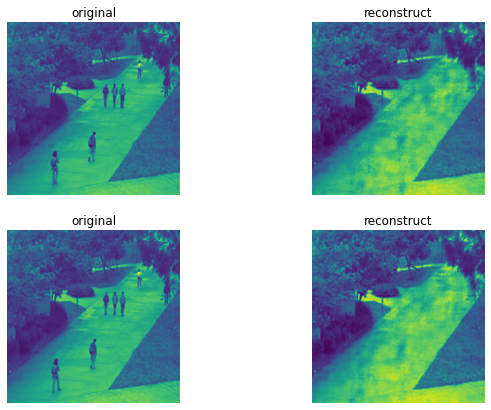

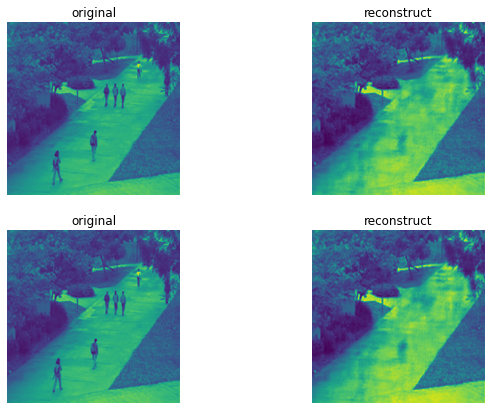

In [64]:
# Plots `n_samples` images. Top row is the original images and the lower row is the reconstructed ones.
n_samples = 10
fig= visualize(vae,BASE + "/Train/Train033")